In [252]:
from glob import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core import Structure
from matminer.featurizers.structure.rdf import RadialDistributionFunction


## 1. read structures and calculated results

In [3]:
df_curve = pd.read_csv('transmission_curves.csv', index_col=0)
df_curve.index.names = ['Frequency (GHz)']

In [2]:
with open('rcsr_structures.json') as f:
    structs = json.load(f)

### 1.1 calculate the transmission area (for Figure 4 usage)

In [110]:
for idx in df_curve.columns:
    df_struct.loc[idx, 'trans_area'] = np.trapz(df_curve[idx], dx=0.01)

## Figure 2

In [5]:
plt.rcParams['figure.figsize'] = (18, 30)

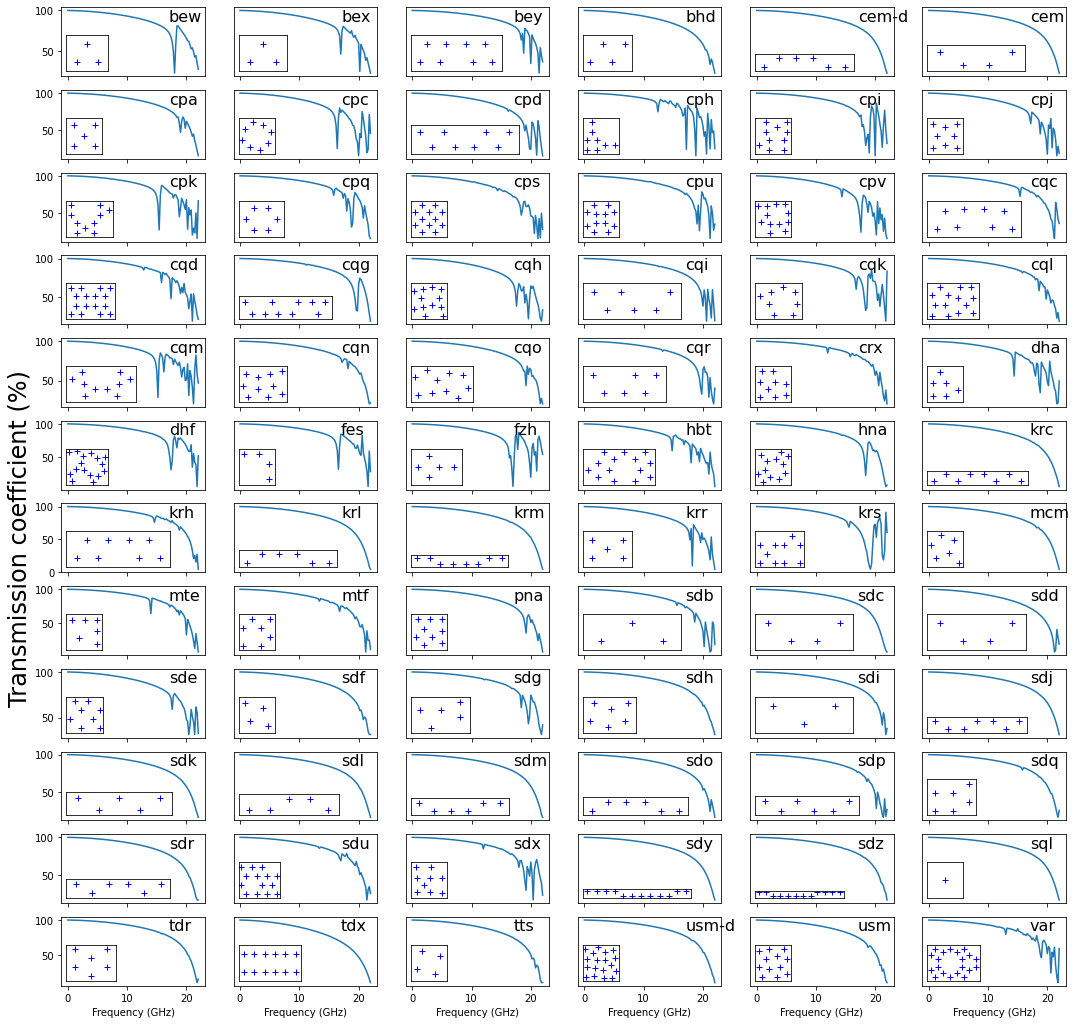

In [6]:
ncol = 6
nrow = 12
max_inset_width = 1.5

fig, axes = plt.subplots(nrow, ncol)
for num, df_col in enumerate(df_curve.columns):
    i = int(num / ncol)
    df_curve[df_col].plot(ax=axes[i,j])
    axes[i,j].annotate(df_col, xy=(0.75, 0.8), xycoords='axes fraction', fontsize=16)
    
    net_name = df_col
    struct = structs[net_name]
    
    if abs(struct['a_b_ratio']) < 1:
        inset_x = 0.5
        inset_y = inset_x / abs(struct['a_b_ratio'])
        
        while inset_y > max_inset_width:
            inset_x = inset_x * 0.9
            inset_y = inset_y * 0.9
            
        axin = inset_axes(axes[i,j], width=inset_y, height=inset_x, loc=3)
        y = np.array(struct['coords'])[:,0]
        x = np.array(struct['coords'])[:,1]    
    else:
        inset_y = 0.5
        inset_x = inset_y * abs(struct['a_b_ratio'])
        
        while inset_x > max_inset_width:
            inset_x = inset_x * 0.8
            inset_y = inset_y * 0.8
            
        axin = inset_axes(axes[i,j], width=inset_x, height=inset_y, loc=3)
        x = np.array(struct['coords'])[:,0]
        y = np.array(struct['coords'])[:,1]
    
        # note that x and y are switched to fit the figure
    axin.plot(x, y, 'b+',)
    axin.set_xlim(0,1)
    axin.set_ylim(0,1)
    axin.set_xticks([])
    axin.set_yticks([])        
    
    if j != 0:
        axes[i,j].set_yticks([])
    if i != (nrow-1):
        axes[i,j].tick_params(labelbottom=False)
        axes[i,j].set_xlabel('')
    if i == 6 and j == 0:
        axes[i,j].set_ylabel('Transmission coefficient (%)', fontsize=24)

## Figure 3

### PCA analysis of transmission curves

In [290]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_curve.transpose())
df_cluster['kmean_label'] = kmeans.labels_

/home/rz/anaconda3/envs/modeling/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [275]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_curve.transpose())
df_cluster['pca_x'] = pca_data[:, 0]
df_cluster['pca_y'] = pca_data[:, 1]

/home/rz/anaconda3/envs/modeling/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


### calculate RDF of the metasurfaces

In [82]:
df_rdf = pd.DataFrame(columns=df_struct.index)

max_dist = 10
bin_size = 0.1
n_bins = max_dist / bin_size
rdf_fn = RadialDistributionFunction(cutoff=max_dist, bin_size=bin_size)

for idx in df_struct.index:
    df_rdf[idx] = rdf_fn.featurize(df_struct.loc[idx, 'structure']) / df_struct.loc[idx, 'natoms'] / 2 / n_bins


### PCA analysis of the RDFs

In [287]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_rdf.transpose())
df_cluster['kmean_label_rdf'] = kmeans.labels_

In [288]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_rdf.transpose())
df_cluster['pca_rdf_x'] = pca_data[:, 0]
df_cluster['pca_rdf_y'] = pca_data[:, 1]

### plot Figure 3

In [297]:
plt.rcParams['figure.figsize'] = (8,4)

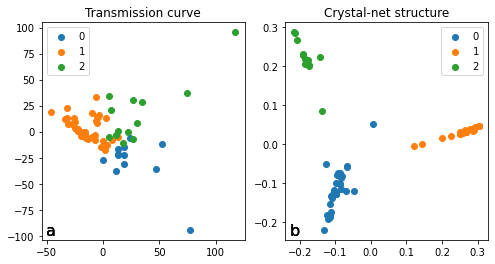

In [301]:
fig, axes = plt.subplots(1, 2)
for i in range(df_cluster['kmean_label'].nunique()):
    df_tmp = df_cluster[df_cluster['kmean_label'] == i]
    axes[0].scatter(df_tmp['pca_x'], df_tmp['pca_y'], label = i)
    axes[0].legend()
    axes[0].annotate('a', xy=(0.02, 0.02), xycoords='axes fraction', fontsize=16)
    axes[0].set_title('Transmission curve')
    
for i in range(df_cluster['kmean_label_rdf'].nunique()):
    df_tmp = df_cluster[df_cluster['kmean_label_rdf'] == i]
    axes[1].scatter(df_tmp['pca_rdf_x'], df_tmp['pca_rdf_y'], label = i)
    axes[1].legend()
    axes[1].annotate('b', xy=(0.02, 0.02), xycoords='axes fraction', fontsize=16)
    axes[1].set_title('Crystal-net structure')

plt.show()

## Figure 4

### build the structrues for pymatgen usage

In [24]:
df_struct = pd.DataFrame(index=structs.keys())

In [41]:
ss = []
natoms = []
for net_name, struct in structs.items():
   
    natom = len(struct['coords'])
    air_box_area = 4 * natom
    a = np.sqrt(air_box_area * abs(struct['a_b_ratio']))
    b = a / abs(struct['a_b_ratio'])
    c = 20
    lattice = np.array([[a, 0, 0], [0, b, 0], [0, 0, c]])
    
    coords = np.concatenate(( np.array(struct['coords']), 
                                np.array([[0.5] * natom]).T ), 
                                axis=1)

    s = Structure(species=['H'] * len(struct['coords']), 
                                coords=coords, 
                                lattice=lattice)
    ss.append(s)
    natoms.append(len(s))

In [162]:
df_struct['structure'] = ss

### Fig 4a: number of atoms

In [42]:
df_struct['natoms'] = natoms

### Fig 4b: number of inequivant atoms

In [164]:
for idx in df_struct.index:
    structure = df_struct.loc[idx, 'structure']
    s = SpacegroupAnalyzer(structure, symprec=0.1)
    df_struct.loc[idx, 'n_uniq_atoms'] = len(set(s.get_symmetry_dataset()['equivalent_atoms']))

### Fig 4c: distance standard deviation

In [138]:
bond_lens = []
for structure in df_struct['structure']:
    bond_lens.append(structure.distance_matrix.round(2))

In [139]:
df_struct['dist_mat'] = bond_lens

In [148]:
for idx in df_struct.index:
    a = np.tril(df_struct['dist_mat'][idx]).flatten()
    b = a[a!=0]
    df_struct.loc[idx, 'bond_std'] = round(b.std(), 2)

### Fig 4d: space group number

In [87]:
for idx in df_struct.index:
    s = df_struct.loc[idx, 'structure']
    df_struct.loc[idx, 'space_group'] = SpacegroupAnalyzer(s, symprec=0.1).get_space_group_number()

### plot Figure 4

In [174]:
plt.rcParams['figure.figsize'] = (8, 8)

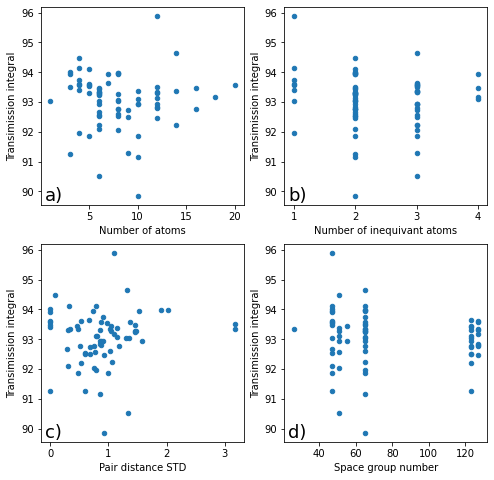

In [183]:
cols = ['natoms', 'n_uniq_atoms', 'bond_std', 'space_group',  ]

xlabels = [
    'Number of atoms', 
    'Number of inequivant atoms', 
    'Pair distance STD',
    'Space group number', 
]

fig_names = [
    'a)',
    'b)',
    'c)',
    'd)',
]

ncol = 2
nrow = 2
fig, axes = plt.subplots(nrow, ncol)

for num, df_col in enumerate(cols):
    i = int(num / ncol)
    j = num % ncol
    df_struct.plot.scatter(x=df_col, 
                           y='trans_area', 
                           ax=axes[i,j], 
                           xlabel=xlabels[num],
                           ylabel='Transimission integral',
                          )
    axes[i,j].annotate(fig_names[num], xy=(0.02, 0.02), xycoords='axes fraction', fontsize=18)